In [83]:
# Libraries
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pickle
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from dotenv import load_dotenv
from supabase import create_client
import os

In [84]:
# Read data
load_dotenv()

SUPABASE_URL = os.getenv("NEXT_PUBLIC_SUPABASE_URL")
SUPABASE_SERVICE_KEY = os.getenv("NEXT_PUBLIC_SUPABASE_SERVICE_KEY")

supabase = create_client(SUPABASE_URL, SUPABASE_SERVICE_KEY)

MAKE = "Porsche"
min_observations = 20

response = (
    supabase.table("bat_completed_auctions")
    .select("year, model, mileage, normalized_color, transmission, sold_price, bid_amount, end_date, status")
    .eq("make", MAKE)
    .not_.is_("mileage", None)
    .not_.is_("transmission", None)
    .execute()
)
df = pd.DataFrame(response.data)

In [85]:
# Top Prices by model
prices = df[['model','sold_price']].groupby('model').mean().sort_values(by='sold_price',ascending=False)
print(prices)

                            sold_price
model                                 
910                          2500000.0
959 Komfort                  1641653.0
935                          1613000.0
Carrera GT                   1490709.5
962C                         1249620.0
...                                ...
Panamera Platinum Edition          NaN
Taycan 4S Cross Turismo            NaN
Taycan GTS                         NaN
Taycan Turbo Cross Turismo         NaN
Turbo S Cabriolet                  NaN

[817 rows x 1 columns]


In [86]:
# Price by model
display_p=df[['model','year','sold_price']]

fig=px.box(display_p,x="model",y="sold_price")
fig.update_layout(title_text='Price vs Model',xaxis_title="Model",yaxis_title="Average Price")

In [87]:
# Filter to models with more than min_observations
counts=df['model'].value_counts()
frequent_models = counts[counts >= min_observations].index

# Filter the data to frequent models
df = df[df['model'].isin(frequent_models)]
popular_labels=frequent_models

colors=['lightslategray',]*len(popular_labels)
colors[0]='crimson'

fig=go.Figure(data=[go.Bar(x=counts[:25],y=popular_labels,marker_color=colors,orientation='h')])
fig.update_layout(title_text='Most represented Models in the Dataset',xaxis_title="Count",yaxis_title="Model")

In [88]:
#distribution of number of cars over the years
dic = {1970+i : sum(df['year']==1970+i) for i in range(55)}
x_dic = [1970 + i for i in range(55)]
y_dic = [dic[1970 + i] for i in range(55)]

# Plot
fig = go.Figure([go.Bar(x=x_dic, y=y_dic)])

fig.update_layout(title="Car year distribution",
                  xaxis_title="Year",
                  yaxis_title="Count Cars sold")


fig.show()

In [89]:
# Distribution of transmission
data_pie = df['transmission'].value_counts()

fig = go.Figure(data=[go.Pie(labels=data_pie.index, values=data_pie.tolist(), textinfo='label+percent',insidetextorientation='radial')])

fig.update_traces(hole=.3, hoverinfo="label+percent+name")

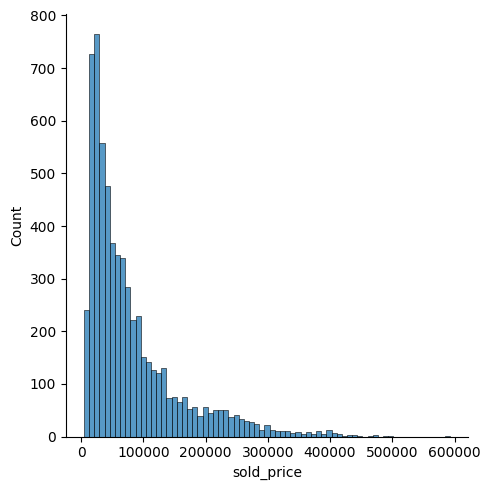

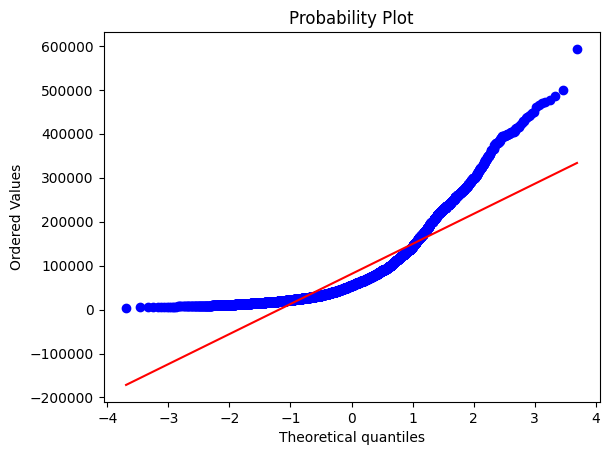

In [90]:
# Replace sold_price with bid_amount and remove outliers
df['sold_price'] = df['sold_price'].fillna(df['bid_amount'])
df = df.dropna()

# Remove outliers
price_threshold = 1000000
df.drop(df[df['sold_price'] >= price_threshold].index,inplace=True)

# Plot distribution of sold_price
sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)


array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'mileage'}>],
       [<Axes: title={'center': 'sold_price'}>,
        <Axes: title={'center': 'bid_amount'}>]], dtype=object)

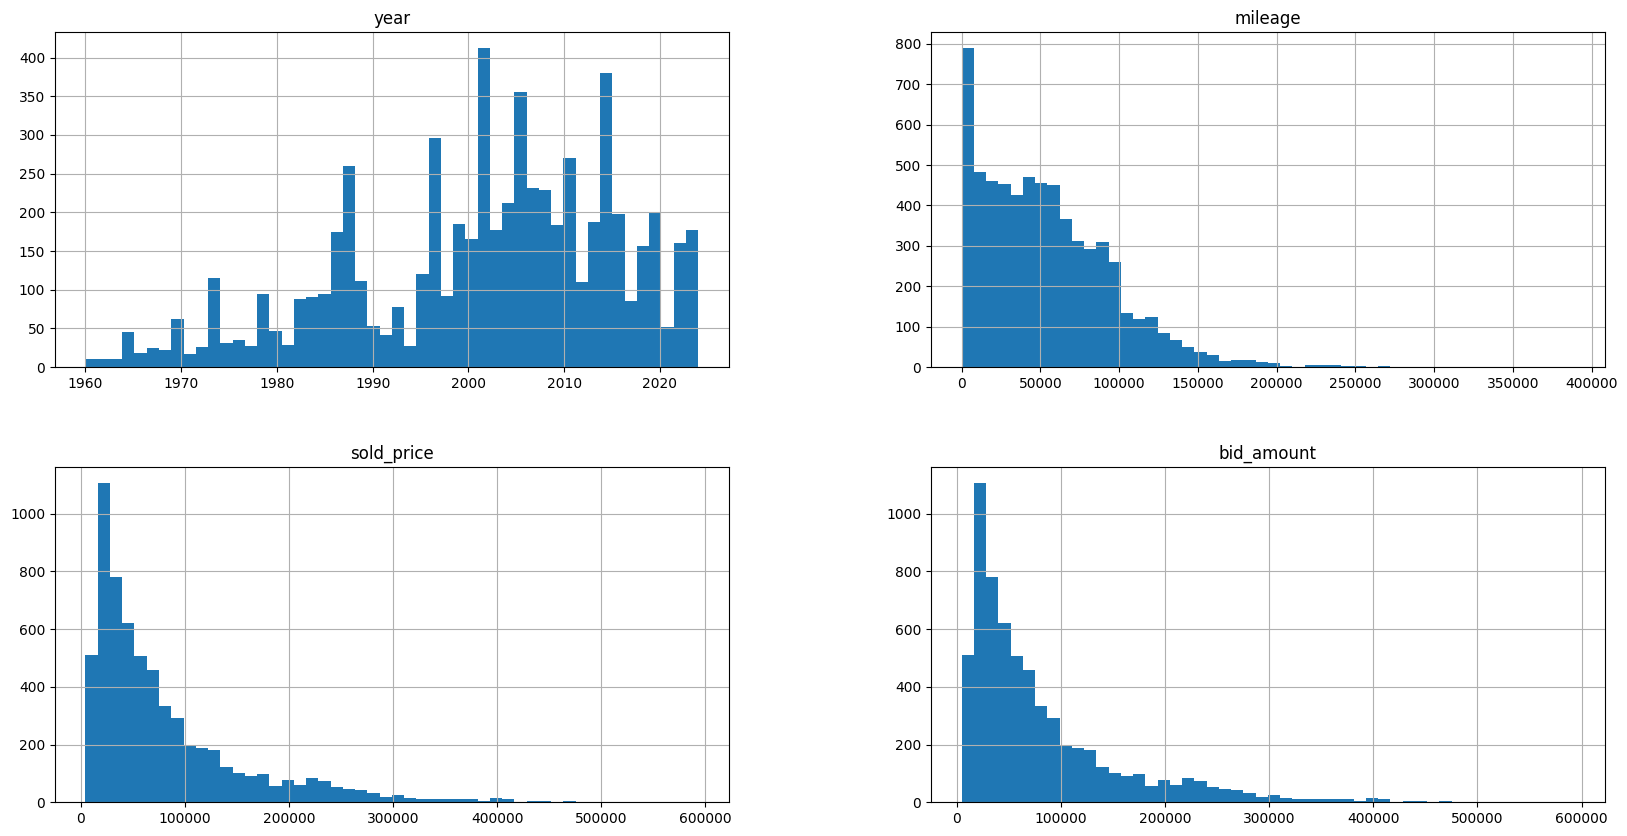

In [91]:
# Data distribution
df.hist(figsize=(20,10),bins = 50)

In [92]:
# Weight by recency
df['days_since_end'] = (pd.to_datetime(date.today()) - pd.to_datetime(df["end_date"])).dt.days
K = 1
T = 360
df['W'] = K*np.exp(-df['days_since_end']/T)


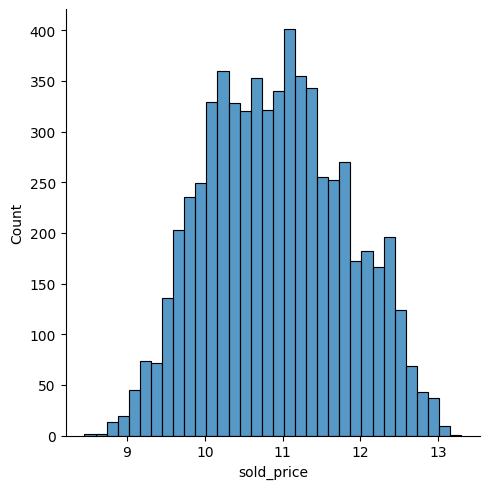

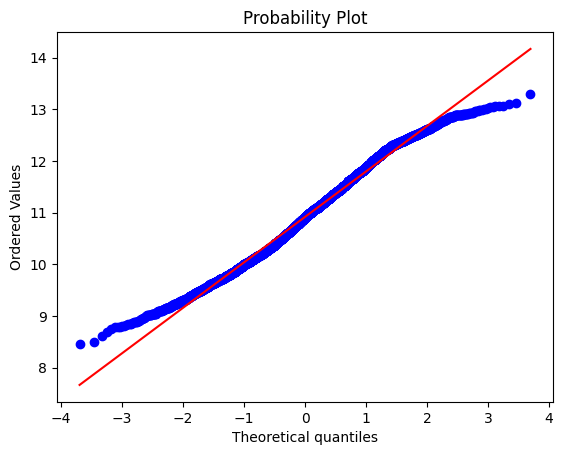

In [93]:
#Log transform sold_price & mileage
df['sold_price'] = np.log(df['sold_price'])
df['mileage'] = np.log1p(df['mileage'])

sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)

In [94]:
# Summarize transformed data
df.describe()

,year,mileage,sold_price,bid_amount,days_since_end,W
count,6276.000000,6276.000000,6276.000000,6276.000000,6276.000000,6276.000000
mean,2001.510198,10.363551,10.918047,81054.498247,368.729924,0.423101
std,14.120982,1.406387,0.884101,76781.830448,210.518596,0.236724
min,1960.000000,0.000000,8.455318,4700.000000,3.000000,0.129812
25%,1992.000000,9.952325,10.231720,27770.250000,190.000000,0.213282
50%,2004.000000,10.757924,10.905956,54500.000000,357.000000,0.370958
75%,2013.000000,11.277216,11.561716,105000.000000,556.250000,0.589914
max,2024.000000,12.871337,13.292950,593000.000000,735.000000,0.991701


In [95]:
# Prepare target and features
y = df["sold_price"]
X = df.drop(["sold_price","bid_amount","end_date", "status", "days_since_end"],axis=1)
X

,year,model,mileage,normalized_color,transmission,W
113,1963,356B Coupe,10.373522,Green,manual,0.258521
114,1961,356B Coupe,11.350418,Blue,manual,0.224997
115,1963,356B Coupe,10.518700,Blue,manual,0.220665
116,1961,356B Coupe,8.476580,Gray,manual,0.204152
117,1963,356B Coupe,10.691968,Silver,manual,0.203021
...,...,...,...,...,...,...
8653,2010,Panamera Turbo,10.933125,Blue,automatic,0.514845
8654,2012,Panamera Turbo,9.952325,Silver,automatic,0.454349
8655,2011,Panamera Turbo,9.741027,Blue,automatic,0.386741
8656,2013,Panamera Turbo,10.239996,White,automatic,0.358796


In [96]:
# Encode categorical features
Lbl_model = LabelEncoder()
Lbl_color = LabelEncoder()
Lbl_trans = LabelEncoder()

#df.make=Lbl.fit_transform(df.make)
X.model=Lbl_model.fit_transform(df.model)
print("Model Mapping:", dict(zip(Lbl_model.classes_, Lbl_model.transform(Lbl_model.classes_))))
X.normalized_color=Lbl_color.fit_transform(df.normalized_color)
print("Color Mapping:", dict(zip(Lbl_color.classes_, Lbl_color.transform(Lbl_color.classes_))))
X.transmission =Lbl_trans.fit_transform(df.transmission)
print("Trans Mapping:", dict(zip(Lbl_trans.classes_, Lbl_trans.transform(Lbl_trans.classes_))))
X

Model Mapping: {'356B Coupe': 0, '356C Coupe': 1, '718 Cayman GT4 6-Speed': 2, '718 Cayman GT4 RS Weissach': 3, '718 Spyder 6-Speed': 4, '911 40th Anniversary 6-Speed': 5, '911 Carrera 2 Cabriolet 5-Speed': 6, '911 Carrera 2 Coupe 5-Speed': 7, '911 Carrera 4 Cabriolet': 8, '911 Carrera 4 Cabriolet 6-Speed': 9, '911 Carrera 4 Coupe 5-Speed': 10, '911 Carrera 4 Coupe 6-Speed': 11, '911 Carrera 4S 6-Speed': 12, '911 Carrera 4S Cabriolet': 13, '911 Carrera 4S Cabriolet 6-Speed': 14, '911 Carrera 4S Coupe': 15, '911 Carrera 4S Coupe 6-Speed': 16, '911 Carrera Cabriolet': 17, '911 Carrera Cabriolet 6-Speed': 18, '911 Carrera Cabriolet G50': 19, '911 Carrera Coupe': 20, '911 Carrera Coupe 6-Speed': 21, '911 Carrera Coupe G50': 22, '911 Carrera GTS Coupe': 23, '911 Carrera GTS Coupe 7-Speed': 24, '911 Carrera RS': 25, '911 Carrera S Cabriolet': 26, '911 Carrera S Cabriolet 6-Speed': 27, '911 Carrera S Coupe': 28, '911 Carrera S Coupe 6-Speed': 29, '911 Carrera S Coupe 7-Speed': 30, '911 Carrer

,year,model,mileage,normalized_color,transmission,W
113,1963,0,10.373522,11,1,0.258521
114,1961,0,11.350418,2,1,0.224997
115,1963,0,10.518700,2,1,0.220665
116,1961,0,8.476580,10,1,0.204152
117,1963,0,10.691968,20,1,0.203021
...,...,...,...,...,...,...
8653,2010,93,10.933125,2,0,0.514845
8654,2012,93,9.952325,20,0,0.454349
8655,2011,93,9.741027,2,0,0.386741
8656,2013,93,10.239996,22,0,0.358796


In [ ]:
# Fit Model
# Features
# year	model	mileage	normalized_color	transmission

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle = True)

car_model_rf = RandomForestRegressor(n_estimators=100, random_state=33, monotonic_cst = [0,0,-1,0,0,0])
car_model_rf.fit(X_train,y_train, sample_weight=X_train['W'])
print('Random Forest Regressor Train Score is : ' ,  car_model_rf.score(X_train, y_train))
print('Random Forest Regressor Test Score is : ' , car_model_rf.score(X_test, y_test)) 

predicted_rf = pd.DataFrame(car_model_rf.predict(X_test), index=X_test.index, columns=['predicted_rf'])
car_model_rf.feature_importances_


Random Forest Regressor Train Score is :  0.9320123482322819
Random Forest Regressor Test Score is :  0.8896096585385276


array([0.21782165, 0.54952356, 0.18252122, 0.01389321, 0.0041515 ,
       0.03208886])

In [98]:
# Inverse transform features
X_analysis = X_test.copy()
X_analysis.model = Lbl_model.inverse_transform(X_test.model)
X_analysis.normalized_color = Lbl_color.inverse_transform(X_test.normalized_color)
X_analysis.transmission = Lbl_trans.inverse_transform(X_test.transmission)
X_analysis

,year,model,mileage,normalized_color,transmission,W
3762,2019,911 GT3 RS Weissach,8.853808,Silver,automatic,0.693041
4061,1981,911SC Coupe,11.736077,White,manual,0.581778
2225,2002,911 Carrera Coupe 6-Speed,10.985310,Red,manual,0.814195
3782,2023,911 GT3 Touring,8.517393,Gray,automatic,0.615013
3881,2019,911 GT3 Touring 6-Speed,8.699681,White,manual,0.477644
...,...,...,...,...,...,...
768,2000,911 Carrera 4 Cabriolet 6-Speed,11.719948,Blue,manual,0.163472
3180,1988,911 Carrera Targa G50,11.350418,Red,manual,0.712562
7404,2012,Cayenne 6-Speed,11.580593,Black,manual,0.499352
3768,2019,911 GT3 RS Weissach,8.987322,White,automatic,0.632337


In [99]:
# Analyze Results: Add target and predicted values
X_analysis = pd.merge(y_test, X_analysis, how='inner', left_index=True, right_index=True)
X_analysis = pd.merge(X_analysis, predicted_rf, how='inner', left_index=True, right_index=True)
X_analysis.sold_price = np.exp(X_analysis.sold_price)
X_analysis.predicted_rf = np.exp(X_analysis.predicted_rf)
X_analysis.mileage = np.exp(X_analysis.mileage) - 1
X_analysis

,sold_price,year,model,mileage,normalized_color,transmission,W,predicted_rf
3762,239000.0,2019,911 GT3 RS Weissach,7000.0,Silver,automatic,0.693041,229348.457103
4061,48911.0,1981,911SC Coupe,125000.0,White,manual,0.581778,54826.240050
2225,29000.0,2002,911 Carrera Coupe 6-Speed,59000.0,Red,manual,0.814195,28582.620372
3782,252000.0,2023,911 GT3 Touring,5000.0,Gray,automatic,0.615013,251164.583058
3881,226000.0,2019,911 GT3 Touring 6-Speed,6000.0,White,manual,0.477644,232831.938395
...,...,...,...,...,...,...,...,...
768,17500.0,2000,911 Carrera 4 Cabriolet 6-Speed,123000.0,Blue,manual,0.163472,21945.149484
3180,67000.0,1988,911 Carrera Targa G50,85000.0,Red,manual,0.712562,71005.878433
7404,21750.0,2012,Cayenne 6-Speed,107000.0,Black,manual,0.499352,18330.762587
3768,231000.0,2019,911 GT3 RS Weissach,8000.0,White,automatic,0.632337,227438.059357


In [100]:
# Define price ranges
def getrange(Price):
    if (Price >= 0 and Price < 50000):
        return '0 - 50000'
    if (Price >= 50000 and Price < 100000):
        return '50000 - 100000'
    if (Price >= 100000 and Price < 150000):
        return '100000 - 150000'
    if (Price >= 150000 and Price < 200000):
        return '150000 - 200000'
    if (Price >= 200000 and Price < 250000):
        return '200000 - 250000'
    if (Price >= 250000 and Price < 300000):
        return '250000 - 300000'
    if (Price >= 300000 and Price < 350000):
        return '300000 - 350000'
    if (Price >= 350000):
        return 'Over 350000'
X_analysis['Price Range'] = X_analysis['sold_price'].apply(lambda x:getrange(x))

X_analysis['Price Range'].value_counts()

Price Range
0 - 50000          590
50000 - 100000     326
100000 - 150000    157
150000 - 200000     59
200000 - 250000     58
250000 - 300000     41
Over 350000         15
300000 - 350000     10
Name: count, dtype: int64

<Axes: xlabel='sold_price', ylabel='predicted_rf'>

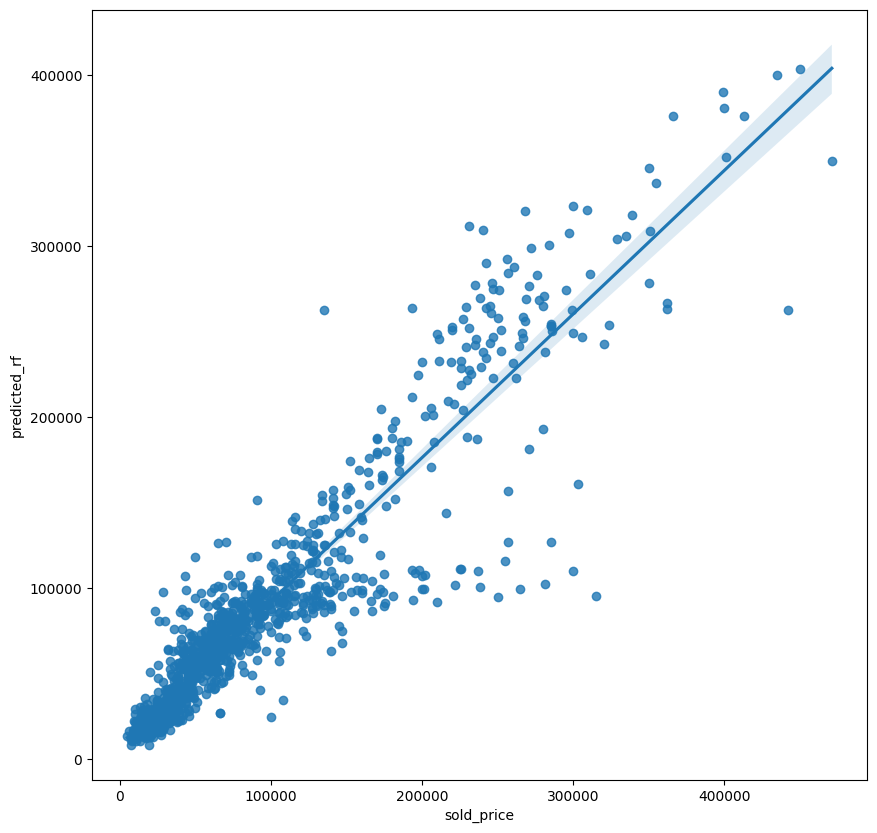

In [101]:
# Plot true vs predicted values scatter

plt.figure(figsize = (10, 10))
sns.regplot(x=X_analysis.sold_price, y=X_analysis.predicted_rf)
#sns.regplot(x=X_analysis.sold_price, y=X_analysis.predicted_xgb)

In [108]:
# Save model
today_date = date.today().strftime('%Y-%m-%d')
pickle.dump(car_model_rf, open('model.pkl','wb'))
pickle.dump(Lbl_model, open('labels_model.pkl','wb'))
pickle.dump(Lbl_color, open('labels_color.pkl','wb'))
pickle.dump(Lbl_trans, open('labels_transmission.pkl','wb'))

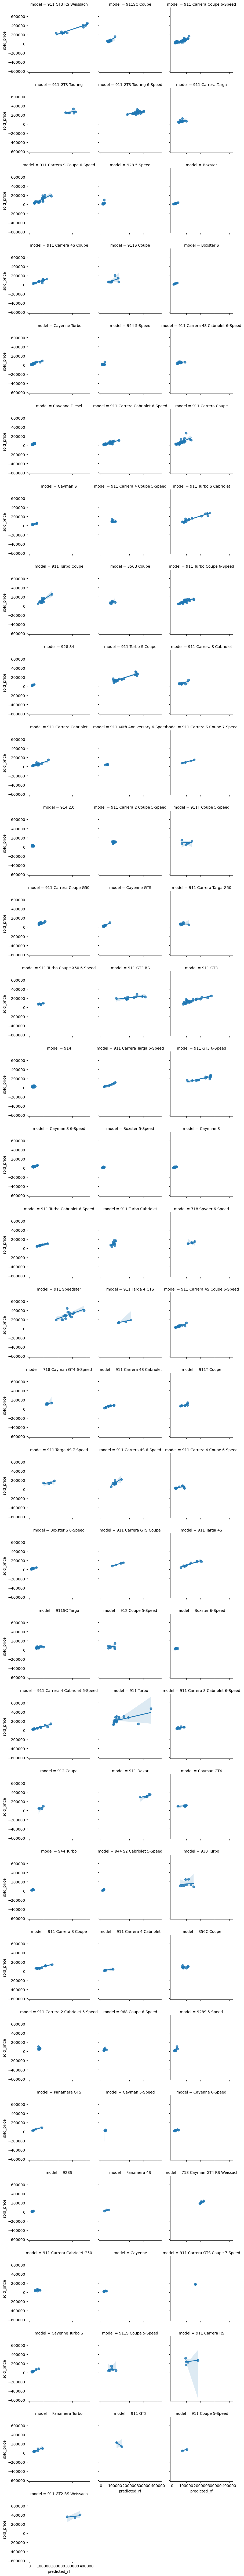

In [70]:
# Predicted vs Sold Price Scatter by model
g = sns.FacetGrid(X_analysis, col="model", col_wrap=3)

# Map scatter plots to the grid
g.map(sns.regplot, "predicted_rf", "sold_price")

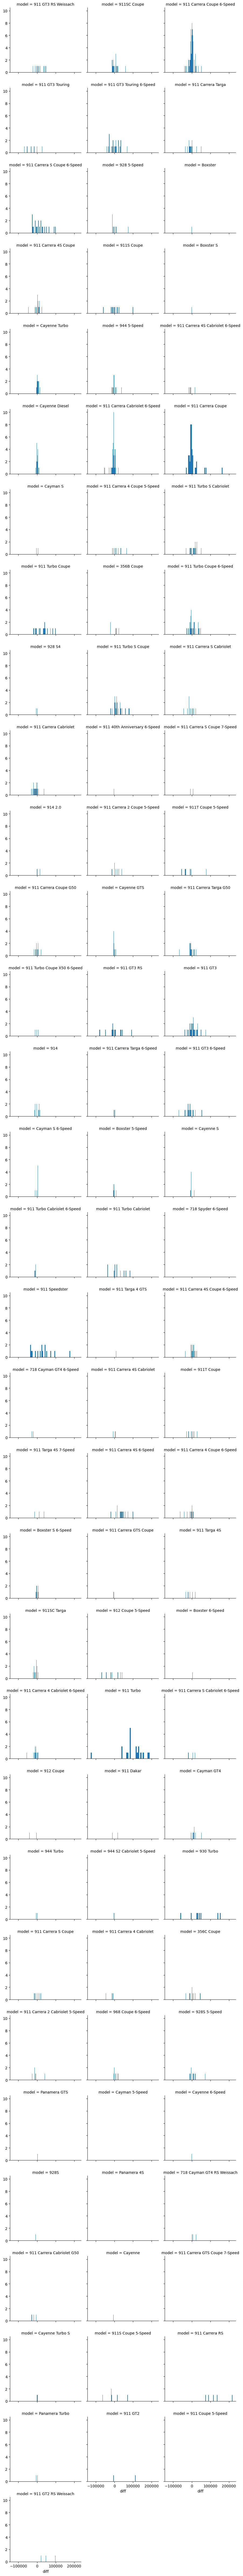

In [ ]:
# Analyze Residuals by model
X_analysis['diff'] = X_analysis.sold_price - X_analysis.predicted_rf
g = sns.FacetGrid(X_analysis, col="model", col_wrap=3)

# Map scatter plots to the grid
g.map(plt.hist, "diff", bins = 50)


In [72]:
# Prediction function

def predict(year, model, mileage, color, transmission, carmodel, W):
    input_data = pd.DataFrame([[year, model, mileage, color, transmission, W]], 
                              columns=["year", "model", "mileage", "normalized_color", "transmission", "W"])
    input_data.model=Lbl_model.transform(input_data.model)
    input_data.normalized_color=Lbl_color.transform(input_data.normalized_color)
    input_data.transmission=Lbl_trans.transform(input_data.transmission)
    input_data.mileage = np.log1p(input_data.mileage)
    price_scaled = carmodel.predict(input_data)

    price = np.exp(price_scaled)
    
    return price[0].round(0)

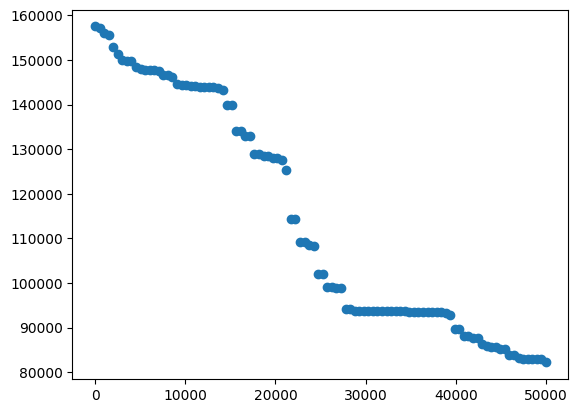

In [74]:
# Run a prediction for a car over a range of mileage
mileage_range = np.linspace(0, 50000, 100)

predictions = []
for mileage in mileage_range:
    prediction = predict(
        year = 2006,
        model = "911 GT3",
        mileage = mileage,
        color = "Silver",
        transmission = "manual",
        carmodel = car_model_rf,
        W = 1
    )
    predictions.append(prediction)

predictions = pd.DataFrame(predictions, columns=["predicted"])
mileage_range = pd.DataFrame(mileage_range, columns=["mileage"])
predictions = pd.merge(predictions, mileage_range, how='inner', left_index=True, right_index=True)
plt.scatter(predictions["mileage"], predictions["predicted"])